In [166]:
import datetime
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import matplotlib.pyplot as plt

from WindowGenerator import WindowGenerator

In [167]:
hash_df = pd.read_csv('hash-rate')
hash_df.rename({'Timestamp': 'Date'}, axis=1, inplace=True)
hash_df.loc[:, 'Date'] = pd.to_datetime(hash_df['Date']).dt.date
# hash_df.set_index('Date', inplace=True)

hash_df = hash_df.loc[hash_df.Date > datetime.date(2012, 2, 1)]

In [168]:
diff_df = pd.read_csv('difficulty')
diff_df.rename({'Timestamp': 'Date'}, axis=1, inplace=True)
diff_df.loc[:, 'Date'] = pd.to_datetime(diff_df['Date']).dt.date

diff_df = diff_df.loc[diff_df.Date > datetime.date(2012, 2, 1)]

In [169]:
df = pd.read_csv('BTC_USD_Bitfinex_Daily.csv')
df = df.iloc[::-1]

# df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)
df.drop(['Open', 'Change %'], axis=1, inplace=True)
df.loc[:, 'Date'] = pd.to_datetime(df['Date']).dt.date


df = pd.merge_ordered(df, hash_df, left_on='Date', right_on='Date', fill_method='ffill')
df = pd.merge_ordered(df, diff_df, left_on='Date', right_on='Date', fill_method='ffill')

df['Vol.'] = df['Vol.'].str.replace('K', '')
df['Vol.'] = df['Vol.'].replace('-', 0)
df['Vol.'] = df['Vol.'].astype(np.float32)*1000

for col in ['Price', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype(np.float32)

# df.rename({'Price': 'close', 'Vol.': 'volume', 'hash-rate': 'hashrate'}, axis=1, inplace=True)
df.rename({'Price': 'close', 'Vol.': 'volume', 'hash-rate': 'hashrate', 'High': 'high', 'Low': 'low'}, axis=1, inplace=True)


df.set_index('Date', inplace=True)
df = df.iloc[2:]

df.loc[:, 'ema12'] = df.ta.ema(10)
df.loc[:, 'ema24'] = df.ta.ema(25)
df.loc[:, 'ema48'] = df.ta.ema(50)

df.drop(['high', 'low'],axis=1,  inplace=True)
# df.drop(['volume', 'hashrate', 'difficulty'],axis=1,  inplace=True)
# df.drop(['volume', 'hashrate', 'difficulty'],axis=1,  inplace=True)

df = df.iloc[48:]
df

,close,volume,hashrate,difficulty,ema12,ema24,ema48
date,,,,,,,
2012-03-23,4.700000,0.0,1.136241e+01,1.498294e+06,4.892832,4.892832,4.892832
2012-03-24,4.700000,0.0,1.151258e+01,1.498294e+06,4.857772,4.857772,4.857772
2012-03-25,4.600000,0.0,1.151258e+01,1.498294e+06,4.810904,4.810904,4.810904
2012-03-26,4.600000,0.0,1.151258e+01,1.498294e+06,4.772558,4.772558,4.772558
2012-03-27,4.800000,0.0,1.151258e+01,1.498294e+06,4.777547,4.777547,4.777547
...,...,...,...,...,...,...,...
2020-08-29,11492.000000,1520.0,1.290754e+08,1.755799e+13,11561.489622,11561.489622,11561.489622
2020-08-30,11729.900391,2100.0,1.290754e+08,1.755799e+13,11592.109762,11592.109762,11592.109762
2020-08-31,11671.000000,2240.0,1.290754e+08,1.755799e+13,11606.453441,11606.453441,11606.453441


In [170]:
# Split data
n = len(df)
print(f'Length of original df: {n}')

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print(f'Length of train df: {len(train_df)}')
print(f'Length of val df: {len(val_df)}')
print(f'Length of test df: {len(test_df)}')

STD = train_df.close.std()
MEAN = train_df.close.mean()

Length of original df: 3086
Length of train df: 2160
Length of val df: 617
Length of test df: 309


In [171]:
def inf_to_zero(x):
    return 0 if x == -np.inf else x

# Standardise data
def standardise(df, column, mean, std):
    vals = df[col].values
    df.loc[:, column+'_normal'] = pd.Series((vals - mean) / std, index=df.index, dtype=np.float64)
    # df.loc[:, column+'_normal'] = pd.Series(np.vectorize(inf_to_zero)(np.log(vals)).astype(np.float64), index=df.index)

norms = {}
cols = [x for x in train_df.columns]

for col in cols:
    vals = train_df[col].values
    std = vals.std()
    mean = vals.mean()
    norms[col+'_std'] = std
    norms[col+'_mean'] = mean
    for df in [train_df, test_df, val_df]:
        standardise(df, col, mean, std)

train_df.drop(cols, axis=1, inplace=True)
val_df.drop(cols, axis=1, inplace=True)
test_df.drop(cols, axis=1, inplace=True)

print(norms)
train_df

{'close_std': 2677.697, 'close_mean': 1199.0394, 'volume_std': 24441.535, 'volume_mean': 14837.777, 'hashrate_std': 3651345.1573555684, 'hashrate_mean': 1819951.847001393, 'difficulty_std': 480312695316.77515, 'difficulty_mean': 242600384181.37073, 'ema12_std': 2627.064787830795, 'ema12_mean': 1178.3138129146705, 'ema24_std': 2627.064787830795, 'ema24_mean': 1178.3138129146705, 'ema48_std': 2627.064787830795, 'ema48_mean': 1178.3138129146705}


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is tr

,close_normal,volume_normal,hashrate_normal,difficulty_normal,ema12_normal,ema24_normal,ema48_normal
date,,,,,,,
2012-03-23,-0.446032,-0.607072,-0.498430,-0.505085,-0.446666,-0.446666,-0.446666
2012-03-24,-0.446032,-0.607072,-0.498430,-0.505085,-0.446680,-0.446680,-0.446680
2012-03-25,-0.446070,-0.607072,-0.498430,-0.505085,-0.446697,-0.446697,-0.446697
2012-03-26,-0.446070,-0.607072,-0.498430,-0.505085,-0.446712,-0.446712,-0.446712
2012-03-27,-0.445995,-0.607072,-0.498430,-0.505085,-0.446710,-0.446710,-0.446710
...,...,...,...,...,...,...,...
2018-02-15,3.285608,2.155848,5.478268,5.479917,2.967490,2.967490,2.967490
2018-02-16,3.347265,1.188641,5.478268,5.479917,3.049704,3.049704,3.049704
2018-02-17,3.680200,1.553185,5.478268,5.479917,3.178670,3.178670,3.178670


In [150]:
INPUT_WIDTH = 15
LABEL_SHIFT = 4
MAX_EPOCHS = 500

In [151]:
window = WindowGenerator(input_width=INPUT_WIDTH, label_width=1, shift=LABEL_SHIFT, 
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         label_columns=['close_normal'])
window

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [11]
Label column name(s): ['close_normal']

In [172]:
LSTM_SIZE = INPUT_WIDTH*len(df.columns)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 6):
            print("\nReached less than 6% loss so cancelling training!")
            self.model.stop_training = True
            
early_stop = myCallback()


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.LSTM(LSTM_SIZE, input_shape=[1, LSTM_SIZE]),
    tf.keras.layers.Dense(int(LSTM_SIZE/2), activation="relu", input_shape=[1, int(LSTM_SIZE/2)]),
    tf.keras.layers.Dense(int(LSTM_SIZE/4), activation="relu", input_shape=[1, int(LSTM_SIZE/4)]),
    tf.keras.layers.Dense(1),
])

# model.compile(loss=tf.keras.losses.Huber(),
#             optimizer=tf.optimizers.Adam(),
#              metrics = ['mape'])

model.compile(loss=tf.losses.MeanAbsolutePercentageError(),
            optimizer=tf.optimizers.Adam())

history = model.fit(window.train, epochs=MAX_EPOCHS, batch_size=96,
                    validation_data=window.val, verbose=1) # , callbacks=[early_stop])

Epoch 1/500
23/23 [==============================] - 1s 35ms/step - loss: 57.9878 - val_loss: 78.0226
Epoch 2/500
23/23 [==============================] - 0s 12ms/step - loss: 35.8549 - val_loss: 69.3572
Epoch 3/500
23/23 [==============================] - 0s 11ms/step - loss: 32.4945 - val_loss: 49.0766
Epoch 4/500
23/23 [==============================] - 0s 11ms/step - loss: 29.7005 - val_loss: 43.1247
Epoch 5/500
23/23 [==============================] - 0s 11ms/step - loss: 29.3557 - val_loss: 37.5663
Epoch 6/500
23/23 [==============================] - 0s 11ms/step - loss: 24.8480 - val_loss: 73.9799
Epoch 7/500
23/23 [==============================] - 0s 11ms/step - loss: 20.1559 - val_loss: 68.6483
Epoch 8/500
23/23 [==============================] - 0s 11ms/step - loss: 18.1550 - val_loss: 63.7472
Epoch 9/500
23/23 [==============================] - 0s 11ms/step - loss: 13.7242 - val_loss: 56.9893
Epoch 10/500
23/23 [==============================] - 0s 11ms/step - loss: 12.3627

23/23 [==============================] - 0s 10ms/step - loss: 9.5891 - val_loss: 20.2465
Epoch 82/500
23/23 [==============================] - 0s 10ms/step - loss: 8.4817 - val_loss: 16.1488
Epoch 83/500
23/23 [==============================] - 0s 11ms/step - loss: 8.4893 - val_loss: 13.0226
Epoch 84/500
23/23 [==============================] - 0s 10ms/step - loss: 9.0601 - val_loss: 23.1959
Epoch 85/500
23/23 [==============================] - 0s 11ms/step - loss: 8.2027 - val_loss: 19.9611
Epoch 86/500
23/23 [==============================] - 0s 10ms/step - loss: 8.4906 - val_loss: 24.4330
Epoch 87/500
23/23 [==============================] - 0s 11ms/step - loss: 8.5660 - val_loss: 22.2080
Epoch 88/500
23/23 [==============================] - 0s 11ms/step - loss: 8.1468 - val_loss: 21.7639
Epoch 89/500
23/23 [==============================] - 0s 11ms/step - loss: 7.8888 - val_loss: 21.3850
Epoch 90/500
23/23 [==============================] - 0s 11ms/step - loss: 8.0757 - val_loss: 2

Epoch 161/500
23/23 [==============================] - 0s 10ms/step - loss: 9.2864 - val_loss: 23.3674
Epoch 162/500
23/23 [==============================] - 0s 11ms/step - loss: 8.7451 - val_loss: 23.4193
Epoch 163/500
23/23 [==============================] - 0s 10ms/step - loss: 7.6006 - val_loss: 17.7028
Epoch 164/500
23/23 [==============================] - 0s 11ms/step - loss: 8.6987 - val_loss: 16.1919
Epoch 165/500
23/23 [==============================] - 0s 11ms/step - loss: 9.3114 - val_loss: 18.3985
Epoch 166/500
23/23 [==============================] - 0s 11ms/step - loss: 8.8890 - val_loss: 17.8084
Epoch 167/500
23/23 [==============================] - 0s 11ms/step - loss: 7.9565 - val_loss: 21.5560
Epoch 168/500
23/23 [==============================] - 0s 11ms/step - loss: 7.9004 - val_loss: 17.2396
Epoch 169/500
23/23 [==============================] - 0s 10ms/step - loss: 7.8654 - val_loss: 17.0911
Epoch 170/500
23/23 [==============================] - 0s 11ms/step - los

23/23 [==============================] - 0s 11ms/step - loss: 7.6619 - val_loss: 15.1615
Epoch 241/500
23/23 [==============================] - 0s 11ms/step - loss: 7.3430 - val_loss: 16.0117
Epoch 242/500
23/23 [==============================] - 0s 11ms/step - loss: 7.5466 - val_loss: 17.4936
Epoch 243/500
23/23 [==============================] - 0s 11ms/step - loss: 7.5423 - val_loss: 23.0040
Epoch 244/500
23/23 [==============================] - 0s 11ms/step - loss: 7.3531 - val_loss: 22.3789
Epoch 245/500
23/23 [==============================] - 0s 11ms/step - loss: 7.9396 - val_loss: 17.1448
Epoch 246/500
23/23 [==============================] - 0s 11ms/step - loss: 7.9283 - val_loss: 21.1842
Epoch 247/500
23/23 [==============================] - 0s 10ms/step - loss: 7.6342 - val_loss: 15.1544
Epoch 248/500
23/23 [==============================] - 0s 11ms/step - loss: 7.1329 - val_loss: 16.7006
Epoch 249/500
23/23 [==============================] - 0s 10ms/step - loss: 7.3134 - va

23/23 [==============================] - 0s 10ms/step - loss: 6.8609 - val_loss: 20.0654
Epoch 320/500
23/23 [==============================] - 0s 11ms/step - loss: 6.9018 - val_loss: 17.1373
Epoch 321/500
23/23 [==============================] - 0s 11ms/step - loss: 6.9425 - val_loss: 18.6274
Epoch 322/500
23/23 [==============================] - 0s 11ms/step - loss: 6.6371 - val_loss: 16.1355
Epoch 323/500
23/23 [==============================] - 0s 10ms/step - loss: 6.6566 - val_loss: 14.8531
Epoch 324/500
23/23 [==============================] - 0s 10ms/step - loss: 7.3754 - val_loss: 20.8673
Epoch 325/500
23/23 [==============================] - 0s 10ms/step - loss: 7.0328 - val_loss: 26.0153
Epoch 326/500
23/23 [==============================] - 0s 11ms/step - loss: 8.6577 - val_loss: 20.1610
Epoch 327/500
23/23 [==============================] - 0s 11ms/step - loss: 7.5235 - val_loss: 26.4597
Epoch 328/500
23/23 [==============================] - 0s 11ms/step - loss: 6.9645 - va

23/23 [==============================] - 0s 11ms/step - loss: 8.0326 - val_loss: 23.6254
Epoch 399/500
23/23 [==============================] - 0s 11ms/step - loss: 6.7444 - val_loss: 24.3774
Epoch 400/500
23/23 [==============================] - 0s 11ms/step - loss: 6.8077 - val_loss: 22.5728
Epoch 401/500
23/23 [==============================] - 0s 11ms/step - loss: 6.4337 - val_loss: 18.6470
Epoch 402/500
23/23 [==============================] - 0s 11ms/step - loss: 6.9422 - val_loss: 22.2992
Epoch 403/500
23/23 [==============================] - 0s 11ms/step - loss: 6.7027 - val_loss: 22.1169
Epoch 404/500
23/23 [==============================] - 0s 11ms/step - loss: 6.5932 - val_loss: 23.2941
Epoch 405/500
23/23 [==============================] - 0s 11ms/step - loss: 6.4693 - val_loss: 23.5229
Epoch 406/500
23/23 [==============================] - 0s 11ms/step - loss: 6.5547 - val_loss: 25.7497
Epoch 407/500
23/23 [==============================] - 0s 10ms/step - loss: 6.6870 - va

23/23 [==============================] - 0s 11ms/step - loss: 6.3328 - val_loss: 26.2170
Epoch 478/500
23/23 [==============================] - 0s 11ms/step - loss: 6.3443 - val_loss: 19.9269
Epoch 479/500
23/23 [==============================] - 0s 11ms/step - loss: 5.9604 - val_loss: 20.2322
Epoch 480/500
23/23 [==============================] - 0s 11ms/step - loss: 5.5313 - val_loss: 26.6989
Epoch 481/500
23/23 [==============================] - 0s 11ms/step - loss: 5.8744 - val_loss: 27.1381
Epoch 482/500
23/23 [==============================] - 0s 10ms/step - loss: 6.0129 - val_loss: 24.5142
Epoch 483/500
23/23 [==============================] - 0s 10ms/step - loss: 5.7994 - val_loss: 22.0119
Epoch 484/500
23/23 [==============================] - 0s 11ms/step - loss: 5.3900 - val_loss: 24.6700
Epoch 485/500
23/23 [==============================] - 0s 10ms/step - loss: 5.8719 - val_loss: 22.0191
Epoch 486/500
23/23 [==============================] - 0s 10ms/step - loss: 5.5464 - va

Minimum training loss: 5.389995574951172
Minimum validation loss: 11.350473403930664


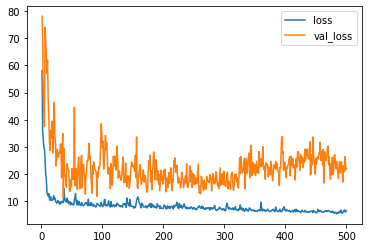

In [173]:
SPLIT = 0
min_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])

print(f'Minimum training loss: {min_loss}')
print(f'Minimum validation loss: {min_val_loss}')

plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['loss'][SPLIT:], label='loss')
plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_loss'][SPLIT:], label='val_loss')
plt.legend()
plt.show()

Minimum training loss: 0.0030730441212654114
Minimum validation loss: 0.0033003513235598803
Minimum training mape: 1.0175961256027222
Minimum validation mape: 0.6800992488861084


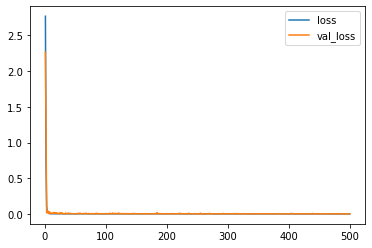

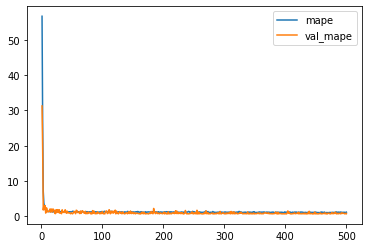

In [105]:
SPLIT = 0
min_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])

min_mape = min(history.history['mape'])
min_val_mape = min(history.history['val_mape'])

print(f'Minimum training loss: {min_loss}')
print(f'Minimum validation loss: {min_val_loss}')

print(f'Minimum training mape: {min_mape}')
print(f'Minimum validation mape: {min_val_mape}')

plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['loss'][SPLIT:], label='loss')
plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_loss'][SPLIT:], label='val_loss')
plt.legend()
plt.show()

plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['mape'][SPLIT:], label='mape')
plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_mape'][SPLIT:], label='val_mape')
plt.legend()
plt.show()

In [174]:
validation_history = model.fit(window.val, epochs=int(MAX_EPOCHS/3), batch_size=1, verbose=1)

Epoch 1/166
7/7 [==============================] - 0s 6ms/step - loss: 14.8196
Epoch 2/166
7/7 [==============================] - 0s 6ms/step - loss: 9.0862
Epoch 3/166
7/7 [==============================] - 0s 6ms/step - loss: 7.2753
Epoch 4/166
7/7 [==============================] - 0s 6ms/step - loss: 7.2380
Epoch 5/166
7/7 [==============================] - 0s 6ms/step - loss: 7.1350
Epoch 6/166
7/7 [==============================] - 0s 6ms/step - loss: 6.8158
Epoch 7/166
7/7 [==============================] - 0s 6ms/step - loss: 6.8224
Epoch 8/166
7/7 [==============================] - 0s 6ms/step - loss: 6.6506
Epoch 9/166
7/7 [==============================] - 0s 6ms/step - loss: 6.7197
Epoch 10/166
7/7 [==============================] - 0s 6ms/step - loss: 6.4152
Epoch 11/166
7/7 [==============================] - 0s 6ms/step - loss: 6.6134
Epoch 12/166
7/7 [==============================] - 0s 6ms/step - loss: 7.3757
Epoch 13/166
7/7 [==============================] - 0s 6ms/s

7/7 [==============================] - 0s 6ms/step - loss: 4.4038
Epoch 105/166
7/7 [==============================] - 0s 6ms/step - loss: 4.4321
Epoch 106/166
7/7 [==============================] - 0s 6ms/step - loss: 4.5909
Epoch 107/166
7/7 [==============================] - 0s 6ms/step - loss: 4.5923
Epoch 108/166
7/7 [==============================] - 0s 6ms/step - loss: 4.5477
Epoch 109/166
7/7 [==============================] - 0s 6ms/step - loss: 4.2584
Epoch 110/166
7/7 [==============================] - 0s 6ms/step - loss: 4.3112
Epoch 111/166
7/7 [==============================] - 0s 6ms/step - loss: 4.3656
Epoch 112/166
7/7 [==============================] - 0s 6ms/step - loss: 4.5599
Epoch 113/166
7/7 [==============================] - 0s 6ms/step - loss: 4.4755
Epoch 114/166
7/7 [==============================] - 0s 6ms/step - loss: 4.2833
Epoch 115/166
7/7 [==============================] - 0s 6ms/step - loss: 4.2356
Epoch 116/166
7/7 [==============================] - 0

Minimum training loss: 3.832744836807251


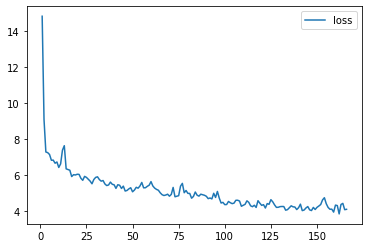

In [175]:
SPLIT = 0
min_loss = min(validation_history.history['loss'])

print(f'Minimum training loss: {min_loss}')

plt.plot([x for x in range(1, int(MAX_EPOCHS/3)+1)][SPLIT:], validation_history.history['loss'][SPLIT:], label='loss')
plt.legend()
plt.show()

In [176]:
model.evaluate(window.test)

4/4 [==============================] - 0s 3ms/step - loss: 6.2697


6.269707202911377

Diff is 318.3839815662941


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


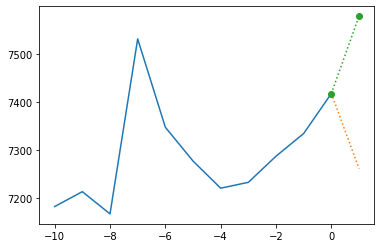

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Diff is 223.75699692685157


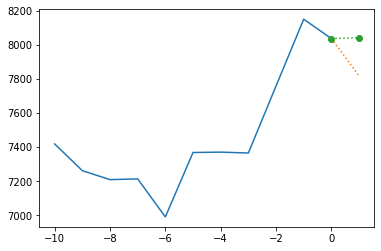

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Diff is 291.18883260479197


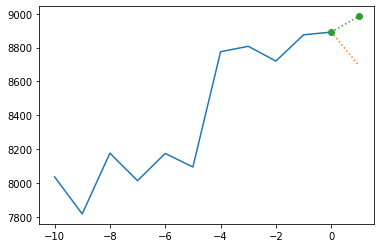

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Diff is -777.5059306760668


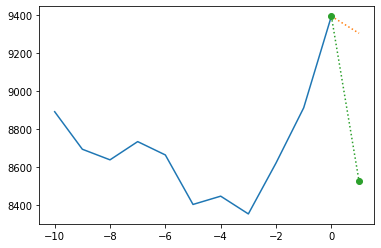

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Diff is -666.4173770009074


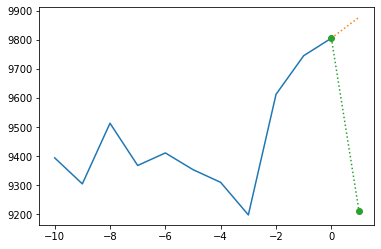

In [177]:
i = 0

for i in range(5, 10):
    new_df = test_df.iloc[(INPUT_WIDTH*i):(INPUT_WIDTH*(i+1))+LABEL_SHIFT]
    input = tf.stack([row.values for _, row in new_df.iloc[:INPUT_WIDTH].iterrows()])
    input = tf.expand_dims(input, axis=0)

#     actual = np.exp(model.predict(input)[0][0])
#     expected = np.exp(new_df.iloc[-1]['close_normal'])
#     new_df.loc[:, 'close'] = pd.Series(np.exp(new_df['close_normal'].values), index=new_df.index)

    actual = (model.predict(input)[0][0] * norms['close_std']) + norms['close_mean']
    expected = (new_df.iloc[-1]['close_normal'] * norms['close_std']) + norms['close_mean']
    new_df.loc[:, 'close'] = pd.Series((new_df['close_normal'].values*norms['close_std'])+norms['close_mean'], index=new_df.index)

    if LABEL_SHIFT > 1:
        plt.plot([x for x in range(-INPUT_WIDTH, 1)], new_df['close'][:INPUT_WIDTH+1])
        plt.plot([x for x in range(0, LABEL_SHIFT)], new_df['close'][INPUT_WIDTH:], linestyle='dotted')
        plt.plot([0, LABEL_SHIFT-1], 
                     [new_df['close'][INPUT_WIDTH], actual],
                     marker='o', linestyle='dotted')
        # plt.set_title(f'{new_df.index[0]} to {new_df.index[-1]}')
        # plt.set_xlabel('Tn (hour)')
        # plt.set_ylabel('Price (USD)')
    else:
        axes[i].plot(new_df.index, new_df['close'])
        axes[i].plot(new_df.index[-1], actual, marker='o')
    print(f'Diff is {actual-expected}')
    plt.show()

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: Sett

Diff is 72.70871466422523
Diff is 187.7077528094378
Diff is -110.9541337032897
Diff is -141.20368553014669
Diff is -175.22793393145912
Diff is -864.8124608821345


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: Sett

Diff is -451.0334923572809
Diff is -516.2144622597189
Diff is 771.2418610678087
Diff is 838.4435854240619


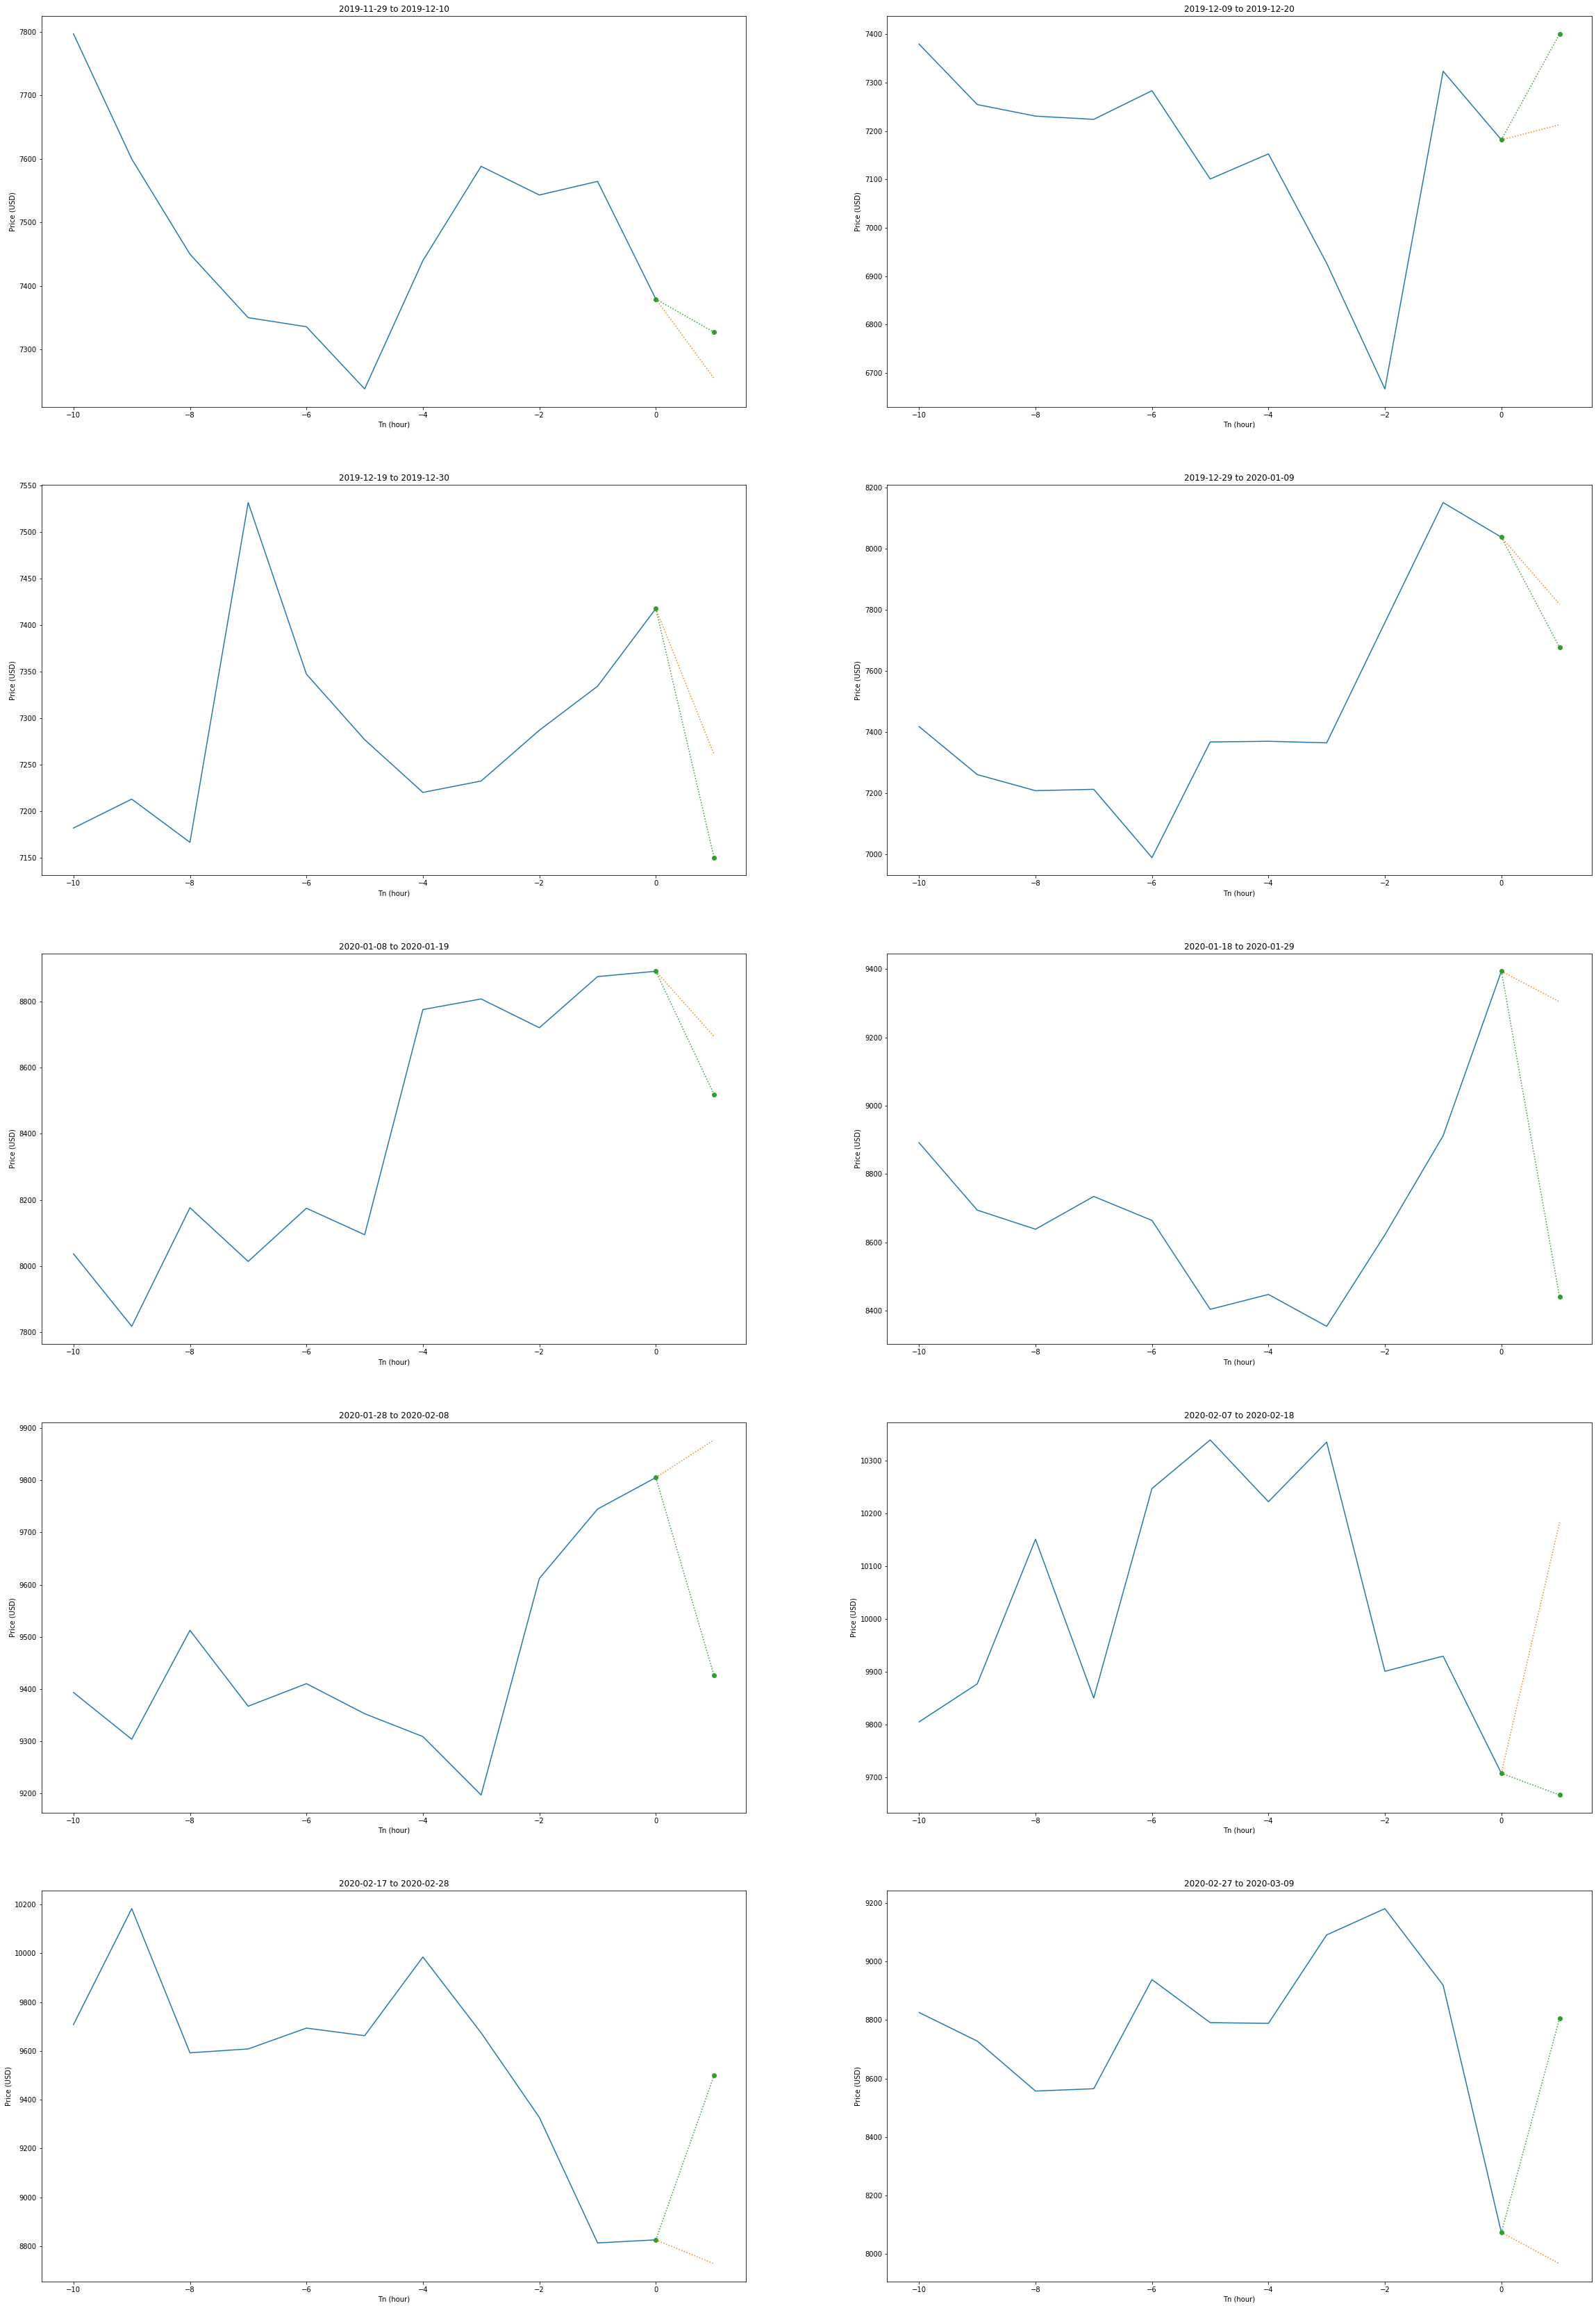

In [137]:
BIAS = 0

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(40, 60))

for i in range(3,:
    new_df = test_df.iloc[(INPUT_WIDTH*i):(INPUT_WIDTH*(i+1))+LABEL_SHIFT]
    input = tf.stack([row.values for _, row in new_df.iloc[:INPUT_WIDTH].iterrows()])
    input = tf.expand_dims(input, axis=0)

    actual = np.exp(model.predict(input)[0][0])
    expected = np.exp(new_df.iloc[-1]['close_normal'])
    
    new_df.loc[:, 'close'] = pd.Series(np.exp(new_df['close_normal'].values), index=new_df.index)
    
    
    if i%2 == 0:
        j = 1
    else:
        j = 0
    
    i = i-3
    map = {0: 0, 1: 0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4}
    i = map[i]
    if LABEL_SHIFT > 1:
        axes[i][j].plot([x for x in range(-INPUT_WIDTH, 1)], new_df['close'][:INPUT_WIDTH+1])
        axes[i][j].plot([x for x in range(0, LABEL_SHIFT)], new_df['close'][INPUT_WIDTH:], linestyle='dotted')
        axes[i][j].plot([0, LABEL_SHIFT-1], 
                     [new_df['close'][INPUT_WIDTH], actual],
                     marker='o', linestyle='dotted')
        axes[i][j].set_title(f'{new_df.index[0]} to {new_df.index[-1]}')
        axes[i][j].set_xlabel('Tn (hour)')
        axes[i][j].set_ylabel('Price (USD)')
    else:
        axes[i].plot(new_df.index, new_df['close'])
        axes[i].plot(new_df.index[-1], actual, marker='o')
    print(f'Diff is {actual-expected}')

plt.show()

In [15]:
model.save('BTC_USD_122448EMAs', save_format='tf')

INFO:tensorflow:Assets written to: BTC_USD_122448EMAs/assets
